In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import segmentation_models_pytorch as smp
import torch
import torchvision
import torchvision.transforms as tt

from facenet_pytorch import MTCNN
from numba import cuda
from pathlib import Path
from segmentation_models_pytorch import utils as smp_utils
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torch import nn
from torch.nn import functional as F
from torchsummary import summary
from torchvision import models
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from tqdm import tqdm
from time import time


%matplotlib inline

In [2]:
torch.__version__

'1.9.1+cu102'

In [3]:
torch.cuda.get_device_name()

'NVIDIA GeForce MX250'

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [5]:
train_tfms = tt.Compose([tt.Grayscale(num_output_channels=1), # Картинки черно-белые
                         tt.Resize((128,128)),
                         # Настройки для расширения датасета
                         tt.RandomHorizontalFlip(),           # Случайные повороты на 90 градусов
                         tt.RandomRotation(30),               # Случайные повороты на 30 градусов
                         tt.ToTensor()])                      

test_tfms = tt.Compose([tt.Grayscale(num_output_channels=1),
                        tt.Resize((128,128)),
                        tt.ToTensor()])

# tt.Normalize(mean=[0.485, 0.456, 0.406],
#              std=[0.229, 0.224, 0.225])

In [6]:
DATA_ROOT = 'D:/Data/Study/facial_emotion_recognition/'

In [7]:
DATA_ROOT_H = 'D:/Data/Study/hand_gesture_recognition_database/'

In [8]:
classes_train = os.listdir(DATA_ROOT + 'train')
classes_test = os.listdir(DATA_ROOT + 'test')
print(f'train Classes - {classes_train}')
print(f'test Classes - {classes_test}')

train Classes - ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
test Classes - ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [9]:
classes_train_gesture = os.listdir(DATA_ROOT_H + '00')
print(f'train Classes - {classes_train_gesture}')

train Classes - ['01_palm', '02_l', '03_fist', '04_fist_moved', '05_thumb', '06_index', '07_ok', '08_palm_moved', '09_c', '10_down']


In [10]:
for emotion in os.listdir(DATA_ROOT + 'train'):
    print(emotion, len(os.listdir(f'{DATA_ROOT}train/{emotion}')))

angry 3995
disgust 436
fear 4097
happy 7215
neutral 4965
sad 4830
surprise 3171


In [11]:
for gesture in os.listdir(DATA_ROOT_H + '00'):
    print(gesture, len(os.listdir(f'{DATA_ROOT_H}00/{gesture}')))

01_palm 200
02_l 200
03_fist 200
04_fist_moved 200
05_thumb 200
06_index 200
07_ok 200
08_palm_moved 200
09_c 200
10_down 200


In [12]:
def digit_to_classname(digit):
    if digit == 0:
        return 'angry'
    elif digit == 1:
        return 'disgust'
    elif digit == 2:
        return 'fear'
    elif digit == 3:
        return 'happy'
    elif digit == 4:
        return 'neutral'
    elif digit == 5:
        return 'sad'
    elif digit == 6:
        return 'surprise'

In [13]:
def digit_to_classname_gesture(digit):
    for idx, itm in enumerate(classes_train_gesture):
        if idx == digit:
            return itm

In [14]:
train_ds_list_gesture = []
test_ds_list_gesture = []
for dir in os.listdir(DATA_ROOT_H):
    train_ds_gesture = ImageFolder(os.path.join(DATA_ROOT_H, dir), train_tfms)
    test_ds_gesture = ImageFolder(os.path.join(DATA_ROOT_H, dir), test_tfms)
    train_ds_list_gesture.append(train_ds_gesture)
    test_ds_list_gesture.append(test_ds_gesture)

train_ds_gesture = ConcatDataset(train_ds_list_gesture)
test_ds_gesture = ConcatDataset(test_ds_list_gesture)

In [15]:
torch.manual_seed(1)

val_split = 0.3
split = int(len(train_ds_gesture) * val_split)
indices = torch.randperm(len(train_ds_gesture))

train_ds_gesture = torch.utils.data.Subset(train_ds_gesture, indices[split:])
test_ds_gesture = torch.utils.data.Subset(test_ds_gesture, indices[:split])

len(train_ds_gesture), len(test_ds_gesture)

(14000, 6000)

In [16]:
train_ds = ImageFolder(DATA_ROOT + 'train', train_tfms)
test_ds = ImageFolder(DATA_ROOT + 'test', test_tfms)

In [17]:
train_ds

Dataset ImageFolder
    Number of datapoints: 28709
    Root location: D:/Data/Study/facial_emotion_recognition/train
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
           )

In [18]:
train_ds.classes

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [15]:
batch_size = 8

In [14]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size, shuffle=False)

torch.Size([1, 128, 128])
tensor(2) fear


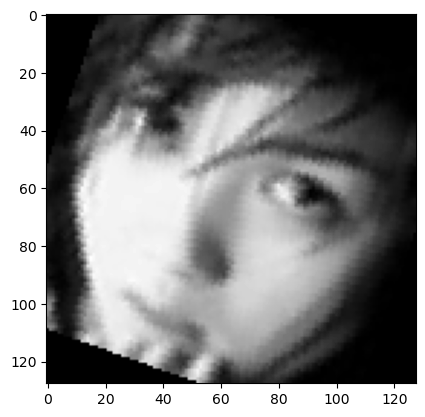

In [15]:
for img, l in train_dl:
    print(img[0].shape)
    print(l[0], digit_to_classname(l[0]))
    plt.imshow(img[0].permute(1, 2, 0)[:,:,0], cmap='gray')
    break

In [16]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ELU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)


class ResNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 128)
        self.conv2 = conv_block(128, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        self.drop1 = nn.Dropout(0.5)
        
        self.conv3 = conv_block(128, 256)
        self.conv4 = conv_block(256, 256, pool=True)
        self.res2 = nn.Sequential(conv_block(256, 256), conv_block(256, 256))
        self.drop2 = nn.Dropout(0.5)
        
        self.conv5 = conv_block(256, 512)
        self.conv6 = conv_block(512, 512, pool=True)
        self.res3 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        self.drop3 = nn.Dropout(0.5)
        
        self.classifier = nn.Sequential(nn.MaxPool2d(6), 
                                        nn.Flatten(),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.drop1(out)
        
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.drop2(out)
        
        out = self.conv5(out)
        out = self.conv6(out)
        out = self.res3(out) + out
        out = self.drop3(out)
        
        out = self.classifier(out)
        return out

In [17]:
model = ResNet(1, len(classes_train)).to(device)

In [18]:
model

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [41]:
print("Parameters:", sum([param.nelement() for param in model.parameters()]))

Parameters: 10782087


In [21]:
max_lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), max_lr)
criterion = nn.CrossEntropyLoss()

In [22]:
num_epochs = 6
train_losses, acc_train, acc_val = [], [], []
start_time = time()

for epoch in range(num_epochs):
    epoch_time = time()
    print(f'Epoch [{epoch + 1} / {num_epochs}]. ')
    model.train()
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    for i, data in enumerate(train_dl, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # обнуляем градиент
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # выводим статистику о процессе обучения
        running_loss += loss.item()
        running_items += len(labels)
        running_right += (labels == torch.max(outputs, 1)[1]).sum()   
            
    print(f'Loss {running_loss / running_items:.3f}. ' \
          f'Acc: {running_right / running_items:.3f}', end='. ')
    train_losses.append(running_loss / running_items)
    acc_train.append(running_right / running_items)

    model.eval()
            
    test_running_right, test_running_total = 0.0, 0.0
    for i, data in enumerate(test_dl, 0):
        test_outputs = model(data[0].to(device))
        test_running_total += len(data[1])
        test_running_right += (data[1].to(device) == torch.max(test_outputs, 1)[1]).sum()

    print(f'Val acc: {test_running_right / test_running_total:.3f}')
    acc_val.append(test_running_right / test_running_total)
    
    print(f'Epoch tooks {(time()-epoch_time)/60:.1f} minutes')

print(f'Training is finished! It tooks {(time()-start_time)/60:.1f} minutes')

Epoch [1 / 6]. 
Loss 0.251. Acc: 0.208. Val acc: 0.231
Epoch tooks 8.8 minutes
Epoch [2 / 6]. 
Loss 0.229. Acc: 0.236. Val acc: 0.292
Epoch tooks 8.5 minutes
Epoch [3 / 6]. 
Loss 0.206. Acc: 0.340. Val acc: 0.413
Epoch tooks 8.4 minutes
Epoch [4 / 6]. 
Loss 0.185. Acc: 0.423. Val acc: 0.484
Epoch tooks 8.4 minutes
Epoch [5 / 6]. 
Loss 0.174. Acc: 0.464. Val acc: 0.502
Epoch tooks 8.4 minutes
Epoch [6 / 6]. 
Loss 0.167. Acc: 0.486. Val acc: 0.490
Epoch tooks 8.4 minutes
Training is finished! It tooks 51.0 minutes


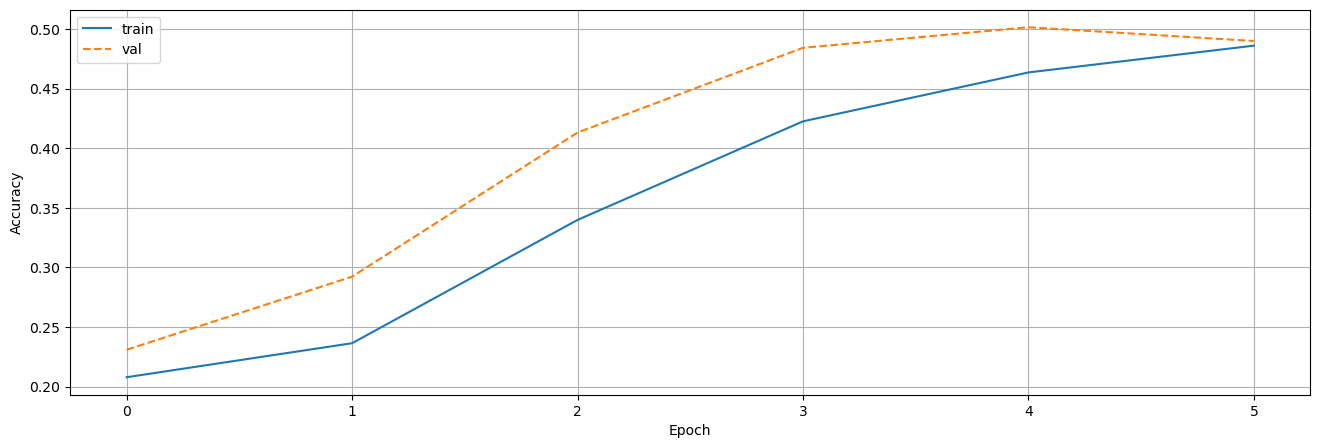

In [23]:
plt.figure(figsize = (16,5))
plt.plot(list(map(lambda x: x.cpu().numpy(), acc_train)),'-',label = f'train')
plt.plot(list(map(lambda x: x.cpu().numpy(), acc_val)),'--',label = f'val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.show()  

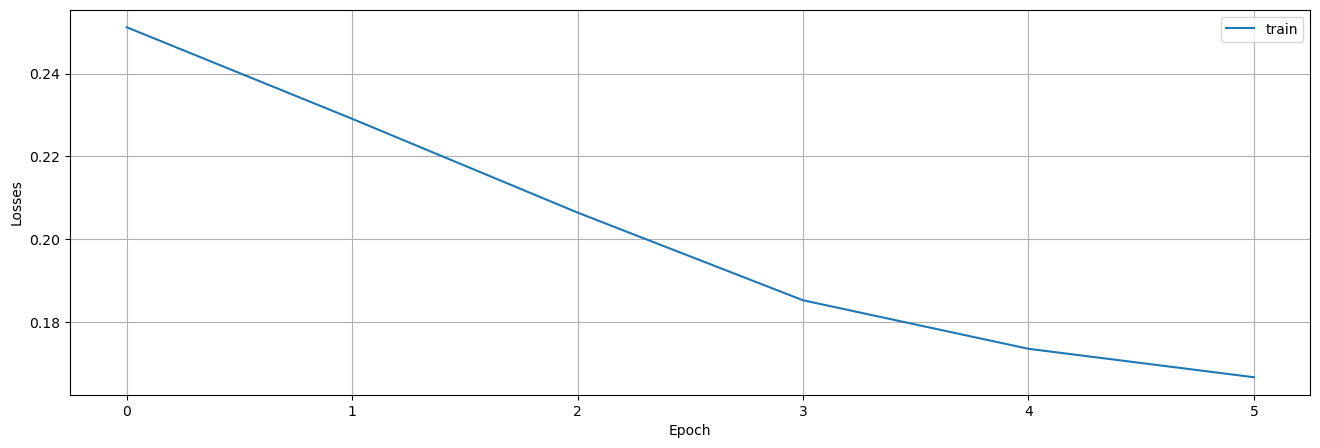

In [24]:
plt.figure(figsize = (16,5))
plt.plot(train_losses,'-',label = f'train')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Losses')
plt.grid()
plt.show()  

In [26]:
torch.save(model, 'emotion_detection_model_self.pth')

#### SimpleCNN

In [15]:
batch_size = 32

In [16]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size, shuffle=False)

In [16]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.LeakyReLU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class SimpleCNN(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 32, pool=True)
        self.conv2 = conv_block(32, 64, pool=True)
        self.conv3 = conv_block(64, 64, pool=True)
        self.conv4 = conv_block(64, 128, pool=True)
        self.classifier = nn.Sequential(nn.Flatten(),
                                        nn.Linear(8192, 128), 
                                        nn.LeakyReLU(inplace=True),
                                        nn.Linear(128, num_classes)) #,
                                       # nn.LeakyReLU(inplace=True),
                                       # nn.Softmax(dim=1))

        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.classifier(out)
        return out

In [18]:
model_SCNN = SimpleCNN(1, len(classes_train)).to(device)

In [19]:
model_SCNN

SimpleCNN(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (

In [21]:
summary(model_SCNN, input_size=(1, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             320
       BatchNorm2d-2         [-1, 32, 128, 128]              64
         LeakyReLU-3         [-1, 32, 128, 128]               0
         MaxPool2d-4           [-1, 32, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          18,496
       BatchNorm2d-6           [-1, 64, 64, 64]             128
         LeakyReLU-7           [-1, 64, 64, 64]               0
         MaxPool2d-8           [-1, 64, 32, 32]               0
            Conv2d-9           [-1, 64, 32, 32]          36,928
      BatchNorm2d-10           [-1, 64, 32, 32]             128
        LeakyReLU-11           [-1, 64, 32, 32]               0
        MaxPool2d-12           [-1, 64, 16, 16]               0
           Conv2d-13          [-1, 128, 16, 16]          73,856
      BatchNorm2d-14          [-1, 128,

In [22]:
max_lr = 0.001
optimizer = torch.optim.Adam(model_SCNN.parameters(), max_lr)
criterion = nn.CrossEntropyLoss()

In [23]:
num_epochs = 25
train_losses, acc_train, acc_val = [], [], []
start_time = time()

for epoch in range(num_epochs):
    epoch_time = time()
    print(f'Epoch [{epoch + 1} / {num_epochs}]. ')
    model_SCNN.train()
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    for i, data in enumerate(train_dl, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # обнуляем градиент
        optimizer.zero_grad()

        outputs = model_SCNN(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # выводим статистику о процессе обучения
        running_loss += loss.item()
        running_items += len(labels)
        running_right += (labels == torch.max(outputs, 1)[1]).sum()   
            
    print(f'Loss {running_loss / running_items:.3f}. ' \
          f'Acc: {running_right / running_items:.3f}', end='. ')
    train_losses.append(running_loss / running_items)
    acc_train.append(running_right / running_items)

    model_SCNN.eval()
            
    test_running_right, test_running_total = 0.0, 0.0
    for i, data in enumerate(test_dl, 0):
        test_outputs = model_SCNN(data[0].to(device))
        test_running_total += len(data[1])
        test_running_right += (data[1].to(device) == torch.max(test_outputs, 1)[1]).sum()

    print(f'Val acc: {test_running_right / test_running_total:.3f}')
    acc_val.append(test_running_right / test_running_total)
    
    print(f'Epoch tooks {(time()-epoch_time)/60:.1f} minutes')

print(f'Training is finished! It tooks {(time()-start_time)/60:.1f} minutes')

Epoch [1 / 25]. 
Loss 0.054. Acc: 0.304. Val acc: 0.368
Epoch tooks 2.7 minutes
Epoch [2 / 25]. 
Loss 0.046. Acc: 0.431. Val acc: 0.435
Epoch tooks 3.1 minutes
Epoch [3 / 25]. 
Loss 0.042. Acc: 0.481. Val acc: 0.496
Epoch tooks 3.3 minutes
Epoch [4 / 25]. 
Loss 0.040. Acc: 0.507. Val acc: 0.526
Epoch tooks 4.9 minutes
Epoch [5 / 25]. 
Loss 0.039. Acc: 0.526. Val acc: 0.492
Epoch tooks 3.9 minutes
Epoch [6 / 25]. 
Loss 0.038. Acc: 0.544. Val acc: 0.544
Epoch tooks 3.4 minutes
Epoch [7 / 25]. 
Loss 0.037. Acc: 0.554. Val acc: 0.554
Epoch tooks 3.1 minutes
Epoch [8 / 25]. 
Loss 0.036. Acc: 0.565. Val acc: 0.544
Epoch tooks 3.2 minutes
Epoch [9 / 25]. 
Loss 0.035. Acc: 0.574. Val acc: 0.549
Epoch tooks 4.1 minutes
Epoch [10 / 25]. 
Loss 0.034. Acc: 0.581. Val acc: 0.586
Epoch tooks 4.1 minutes
Epoch [11 / 25]. 
Loss 0.034. Acc: 0.589. Val acc: 0.575
Epoch tooks 3.4 minutes
Epoch [12 / 25]. 
Loss 0.033. Acc: 0.594. Val acc: 0.580
Epoch tooks 3.3 minutes
Epoch [13 / 25]. 
Loss 0.033. Acc: 0.

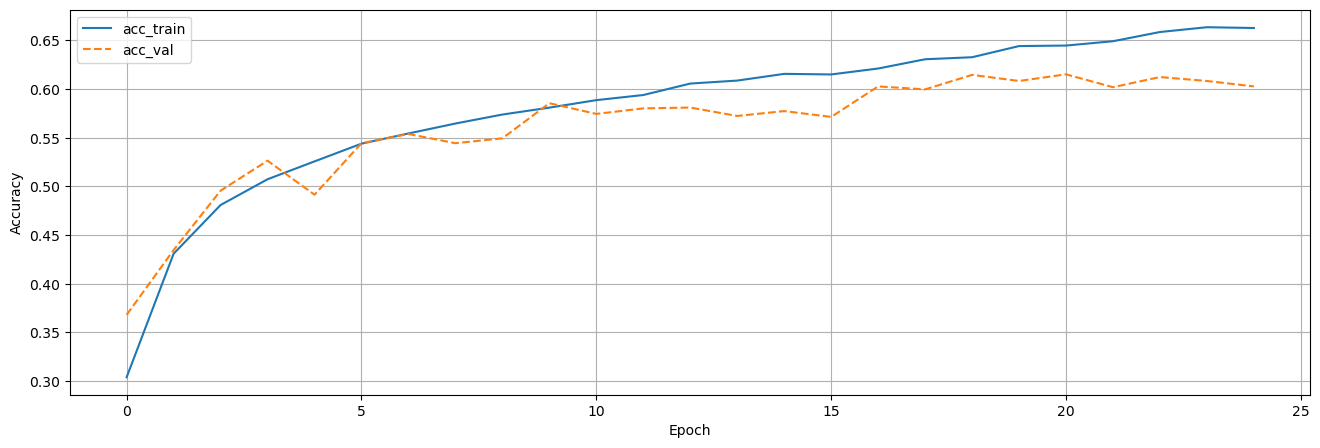

In [28]:
plt.figure(figsize = (16,5))
plt.plot(list(map(lambda x: x.cpu().numpy(), acc_train)),'-',label = f'acc_train')
plt.plot(list(map(lambda x: x.cpu().numpy(), acc_val)),'--',label = f'acc_val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.show()  

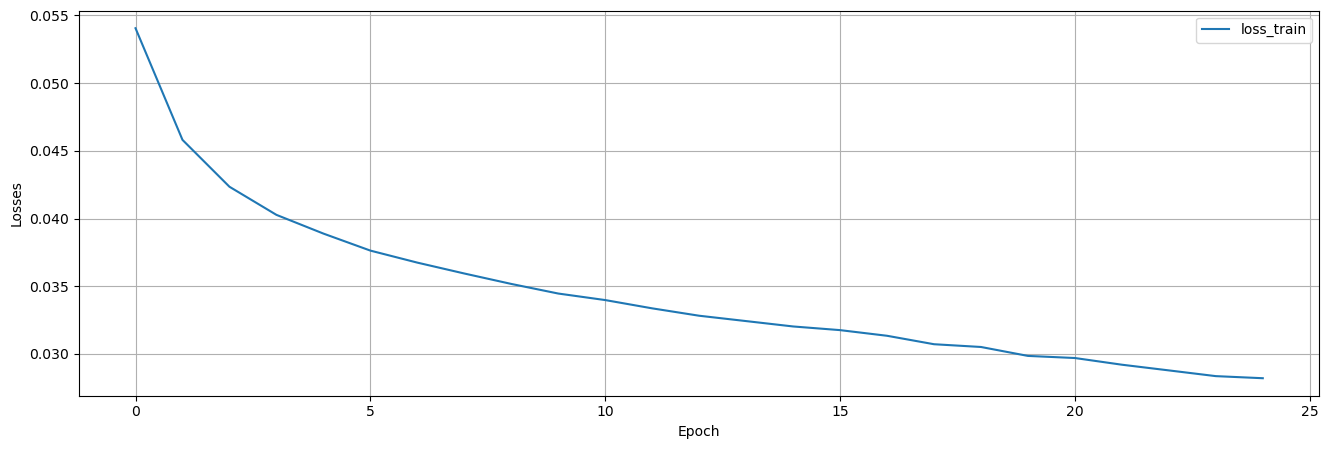

In [29]:
plt.figure(figsize = (16,5))
plt.plot(train_losses,'-',label = f'loss_train')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Losses')
plt.grid()
plt.show()  

In [30]:
torch.save(model_SCNN, 'emotion_detection_SCNN_model.pth')

In [31]:
torch.save(model_SCNN.state_dict(), 'emotion_detection_SCNN_model_weight.pth')

#### SimpleCNN_gesture

In [20]:
batch_size = 32

In [21]:
train_dl_gesture = DataLoader(train_ds_gesture, batch_size, shuffle=True)
test_dl_gesture = DataLoader(test_ds_gesture, batch_size, shuffle=False)

In [17]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.LeakyReLU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class SimpleCNN_gesture(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 32, pool=True)
        self.conv2 = conv_block(32, 64, pool=True)
        self.conv3 = conv_block(64, 64, pool=True)
        self.conv4 = conv_block(64, 128, pool=True)
        self.classifier = nn.Sequential(nn.Flatten(),
                                        nn.Linear(8192, 128), 
                                        nn.LeakyReLU(inplace=True),
                                        nn.Linear(128, num_classes)) #,
                                       # nn.LeakyReLU(inplace=True),
                                       # nn.Softmax(dim=1))

        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.classifier(out)
        return out

In [23]:
model_SCNN_gesture = SimpleCNN_gesture(1, len(classes_train_gesture)).to(device)

In [24]:
model_SCNN_gesture

SimpleCNN_gesture(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

In [25]:
summary(model_SCNN_gesture, input_size=(1, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             320
       BatchNorm2d-2         [-1, 32, 128, 128]              64
         LeakyReLU-3         [-1, 32, 128, 128]               0
         MaxPool2d-4           [-1, 32, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          18,496
       BatchNorm2d-6           [-1, 64, 64, 64]             128
         LeakyReLU-7           [-1, 64, 64, 64]               0
         MaxPool2d-8           [-1, 64, 32, 32]               0
            Conv2d-9           [-1, 64, 32, 32]          36,928
      BatchNorm2d-10           [-1, 64, 32, 32]             128
        LeakyReLU-11           [-1, 64, 32, 32]               0
        MaxPool2d-12           [-1, 64, 16, 16]               0
           Conv2d-13          [-1, 128, 16, 16]          73,856
      BatchNorm2d-14          [-1, 128,

In [26]:
max_lr = 0.001
optimizer = torch.optim.Adam(model_SCNN_gesture.parameters(), max_lr)
criterion = nn.CrossEntropyLoss()

In [27]:
num_epochs = 5
train_losses, acc_train, acc_val = [], [], []
start_time = time()

for epoch in range(num_epochs):
    epoch_time = time()
    print(f'Epoch [{epoch + 1} / {num_epochs}]. ')
    model_SCNN_gesture.train()
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    for i, data in enumerate(train_dl_gesture, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # обнуляем градиент
        optimizer.zero_grad()

        outputs = model_SCNN_gesture(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # выводим статистику о процессе обучения
        running_loss += loss.item()
        running_items += len(labels)
        running_right += (labels == torch.max(outputs, 1)[1]).sum()   
            
    print(f'Loss {running_loss / running_items:.3f}. ' \
          f'Acc: {running_right / running_items:.3f}', end='. ')
    train_losses.append(running_loss / running_items)
    acc_train.append(running_right / running_items)

    model_SCNN_gesture.eval()
            
    test_running_right, test_running_total = 0.0, 0.0
    for i, data in enumerate(test_dl_gesture, 0):
        test_outputs = model_SCNN_gesture(data[0].to(device))
        test_running_total += len(data[1])
        test_running_right += (data[1].to(device) == torch.max(test_outputs, 1)[1]).sum()

    print(f'Val acc: {test_running_right / test_running_total:.3f}')
    acc_val.append(test_running_right / test_running_total)
    
    print(f'Epoch tooks {(time()-epoch_time)/60:.1f} minutes')

print(f'Training is finished! It tooks {(time()-start_time)/60:.1f} minutes')

Epoch [1 / 5]. 
Loss 0.017. Acc: 0.823. Val acc: 0.982
Epoch tooks 3.7 minutes
Epoch [2 / 5]. 
Loss 0.002. Acc: 0.979. Val acc: 0.946
Epoch tooks 3.7 minutes
Epoch [3 / 5]. 
Loss 0.002. Acc: 0.985. Val acc: 0.975
Epoch tooks 3.7 minutes
Epoch [4 / 5]. 
Loss 0.001. Acc: 0.990. Val acc: 0.998
Epoch tooks 3.7 minutes
Epoch [5 / 5]. 
Loss 0.001. Acc: 0.989. Val acc: 0.998
Epoch tooks 3.6 minutes
Training is finished! It tooks 18.3 minutes


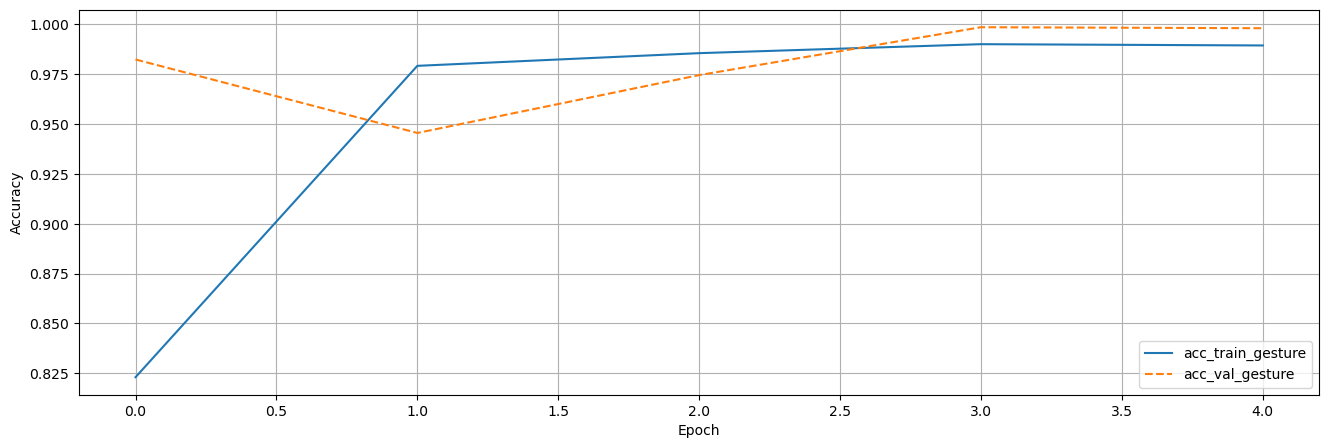

In [28]:
plt.figure(figsize = (16,5))
plt.plot(list(map(lambda x: x.cpu().numpy(), acc_train)),'-',label = f'acc_train_gesture')
plt.plot(list(map(lambda x: x.cpu().numpy(), acc_val)),'--',label = f'acc_val_gesture')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.show()  

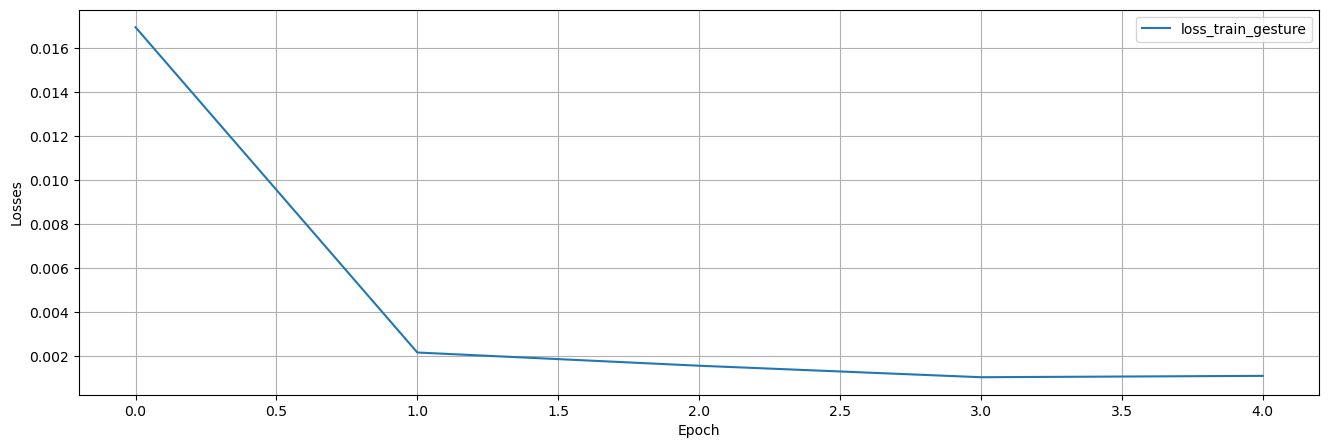

In [29]:
plt.figure(figsize = (16,5))
plt.plot(train_losses,'-',label = f'loss_train_gesture')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Losses')
plt.grid()
plt.show()  

In [30]:
torch.save(model_SCNN_gesture, 'emotion_detection_SCNN_gesture_model.pth')

In [31]:
torch.save(model_SCNN_gesture.state_dict(), 'emotion_detection_SCNN_gesture_model_weight.pth')

#### Pretrained resnet50

In [17]:
resnet = models.resnet50(pretrained=True)

In [18]:
for param in resnet.parameters():
    param.requires_grad = False

In [19]:
in_features = resnet.fc.in_features
fc = nn.Linear(in_features=in_features, out_features = len(classes_train))
resnet.fc = fc
summary(resnet.to(device), input_size=(3, 48, 48))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 24, 24]           9,408
       BatchNorm2d-2           [-1, 64, 24, 24]             128
              ReLU-3           [-1, 64, 24, 24]               0
         MaxPool2d-4           [-1, 64, 12, 12]               0
            Conv2d-5           [-1, 64, 12, 12]           4,096
       BatchNorm2d-6           [-1, 64, 12, 12]             128
              ReLU-7           [-1, 64, 12, 12]               0
            Conv2d-8           [-1, 64, 12, 12]          36,864
       BatchNorm2d-9           [-1, 64, 12, 12]             128
             ReLU-10           [-1, 64, 12, 12]               0
           Conv2d-11          [-1, 256, 12, 12]          16,384
      BatchNorm2d-12          [-1, 256, 12, 12]             512
           Conv2d-13          [-1, 256, 12, 12]          16,384
      BatchNorm2d-14          [-1, 256,

In [20]:
params_to_update = []
for name, param in resnet.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params_to_update, lr=0.001)

In [21]:
def train(model,
          criterion,
          optimizer,
          train_dataloader,
          test_dataloader,
          print_every,
          num_epoch):
    steps = 0
    train_losses, val_losses, acc_train, acc_val = [], [], [], []
    
    model.to(device)
    for epoch in tqdm(range(num_epoch)):
        running_loss = 0
        correct_train = 0
        total_train = 0
        start_time = time()
        iter_time = time()
        
        print(f'Epoch [{epoch + 1}] / [{num_epoch}].')
        model.train()
        for i, (images, labels) in enumerate(train_dataloader):
            steps += 1
            images = images.to(device)
            labels = labels.to(device)
            
            # forward pass
            output = model(images)
            loss = criterion(output, labels)
            
            correct_train += (torch.max(output, dim=1)[1]==labels).sum()
            total_train += labels.size(0)
            
            # backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            # Logging
            if steps % print_every == 0:
                pass
        print(f'Train Loss {running_loss / steps:.3f}.', end=' ')
        print(f'Train acc: {correct_train / total_train:.3f}', end=' ')
        with torch.no_grad():
            model.eval()
            correct_val, total_val = 0, 0
            val_loss = 0
            for images, labels in test_dataloader:
                images = images.to(device)
                labels = labels.to(device)
                output = model(images)
                loss = criterion(output, labels)
                val_loss += loss.item()
                correct_val += (torch.max(output, dim=1)[1]==labels).sum()
                total_val += labels.size(0)
            torch.cuda.empty_cache()
        print(f'Val loss {val_loss / len(test_dataloader):.3f}. Val acc {correct_val / total_val:.3f}.', end = ' ')
        print(f'Took {time() - iter_time:.3f} seconds')
        iter_time = time()

        acc_train.append(correct_train / total_train)
        acc_val.append(correct_val / total_val)
        train_losses.append(running_loss / total_train)
        val_losses.append(val_loss / total_val)
    
    print(f'Training took {(time()-start_time)/60:.1f} minutes')
        
    return model, train_losses, val_losses, acc_train, acc_val

In [22]:
print_every = 1000
num_epoch = 20
torch.cuda.empty_cache()
resnet, train_losses, val_losses, acc_train, acc_val = train(
    model=resnet,
    criterion=criterion,
    optimizer=optimizer,
    train_dataloader=train_dl,
    test_dataloader=test_dl,
    print_every=print_every,
    num_epoch=num_epoch
)

torch.save(resnet, 'emotion_detection_model.pth')

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Epoch [1] / [20].
Batch [225]/[225]. Train Loss 1.760. Train acc: 0.295 

  5%|████                                                                              | 1/20 [03:04<58:19, 184.21s/it]

Val loss 1.724. Val acc 0.326. Took 184.208 seconds
Epoch [2] / [20].
Batch [225]/[225]. Train Loss 0.857. Train acc: 0.322 

 10%|████████▏                                                                         | 2/20 [04:41<39:50, 132.83s/it]

Val loss 1.739. Val acc 0.332. Took 96.860 seconds
Epoch [3] / [20].
Batch [225]/[225]. Train Loss 0.568. Train acc: 0.327 

 15%|████████████▎                                                                     | 3/20 [06:16<32:51, 115.96s/it]

Val loss 1.739. Val acc 0.329. Took 95.880 seconds
Epoch [4] / [20].
Batch [225]/[225]. Train Loss 0.423. Train acc: 0.330 

 20%|████████████████▍                                                                 | 4/20 [07:53<28:53, 108.36s/it]

Val loss 1.687. Val acc 0.354. Took 96.712 seconds
Epoch [5] / [20].
Batch [225]/[225]. Train Loss 0.338. Train acc: 0.333 

 25%|████████████████████▌                                                             | 5/20 [09:40<26:57, 107.86s/it]

Val loss 1.684. Val acc 0.357. Took 106.962 seconds
Epoch [6] / [20].
Batch [225]/[225]. Train Loss 0.281. Train acc: 0.335 

 30%|████████████████████████▌                                                         | 6/20 [11:23<24:48, 106.29s/it]

Val loss 1.778. Val acc 0.314. Took 103.241 seconds
Epoch [7] / [20].
Batch [225]/[225]. Train Loss 0.240. Train acc: 0.339 

 35%|████████████████████████████▋                                                     | 7/20 [13:04<22:37, 104.42s/it]

Val loss 1.773. Val acc 0.339. Took 100.571 seconds
Epoch [8] / [20].
Batch [225]/[225]. Train Loss 0.211. Train acc: 0.339 

 40%|████████████████████████████████▊                                                 | 8/20 [14:51<21:01, 105.12s/it]

Val loss 1.707. Val acc 0.346. Took 106.633 seconds
Epoch [9] / [20].
Batch [225]/[225]. Train Loss 0.187. Train acc: 0.340 

 45%|████████████████████████████████████▉                                             | 9/20 [16:41<19:34, 106.74s/it]

Val loss 1.730. Val acc 0.327. Took 110.301 seconds
Epoch [10] / [20].
Batch [225]/[225]. Train Loss 0.168. Train acc: 0.341 

 50%|████████████████████████████████████████▌                                        | 10/20 [18:37<18:15, 109.53s/it]

Val loss 1.671. Val acc 0.354. Took 115.776 seconds
Epoch [11] / [20].
Batch [225]/[225]. Train Loss 0.152. Train acc: 0.344 

 55%|████████████████████████████████████████████▌                                    | 11/20 [20:29<16:33, 110.38s/it]

Val loss 1.681. Val acc 0.351. Took 112.297 seconds
Epoch [12] / [20].
Batch [225]/[225]. Train Loss 0.139. Train acc: 0.342 

 60%|████████████████████████████████████████████████▌                                | 12/20 [22:14<14:30, 108.87s/it]

Val loss 1.674. Val acc 0.342. Took 105.428 seconds
Epoch [13] / [20].
Batch [225]/[225]. Train Loss 0.129. Train acc: 0.342 

 65%|████████████████████████████████████████████████████▋                            | 13/20 [23:59<12:32, 107.53s/it]

Val loss 1.678. Val acc 0.357. Took 104.421 seconds
Epoch [14] / [20].
Batch [225]/[225]. Train Loss 0.119. Train acc: 0.344 

 70%|████████████████████████████████████████████████████████▋                        | 14/20 [25:42<10:37, 106.19s/it]

Val loss 1.684. Val acc 0.349. Took 103.110 seconds
Epoch [15] / [20].
Batch [225]/[225]. Train Loss 0.111. Train acc: 0.350 

 75%|████████████████████████████████████████████████████████████▊                    | 15/20 [27:38<09:06, 109.29s/it]

Val loss 1.708. Val acc 0.340. Took 116.465 seconds
Epoch [16] / [20].
Batch [225]/[225]. Train Loss 0.104. Train acc: 0.343 

 80%|████████████████████████████████████████████████████████████████▊                | 16/20 [29:17<07:04, 106.22s/it]

Val loss 1.675. Val acc 0.353. Took 99.095 seconds
Epoch [17] / [20].
Batch [225]/[225]. Train Loss 0.098. Train acc: 0.350 

 85%|████████████████████████████████████████████████████████████████████▊            | 17/20 [31:02<05:16, 105.57s/it]

Val loss 1.716. Val acc 0.355. Took 104.070 seconds
Epoch [18] / [20].
Batch [225]/[225]. Train Loss 0.093. Train acc: 0.346 

 90%|████████████████████████████████████████████████████████████████████████▉        | 18/20 [32:43<03:28, 104.22s/it]

Val loss 1.671. Val acc 0.362. Took 101.078 seconds
Epoch [19] / [20].
Batch [225]/[225]. Train Loss 0.088. Train acc: 0.348 

 95%|████████████████████████████████████████████████████████████████████████████▉    | 19/20 [34:26<01:43, 103.84s/it]

Val loss 1.738. Val acc 0.343. Took 102.930 seconds
Epoch [20] / [20].
Batch [225]/[225]. Train Loss 0.084. Train acc: 0.345 

100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [36:03<00:00, 108.19s/it]

Val loss 1.747. Val acc 0.340. Took 97.726 seconds
Training took 1.6 minutes


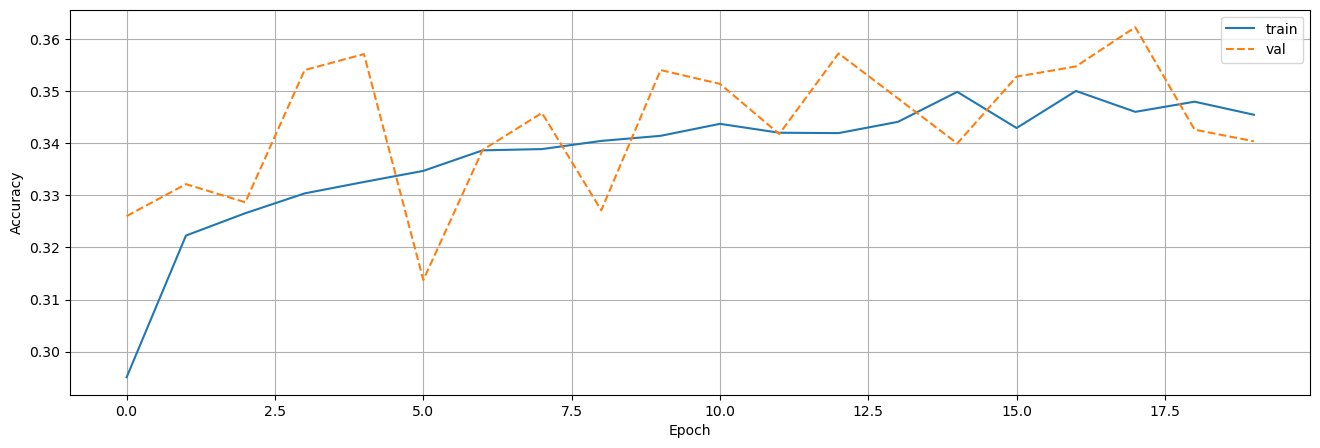

In [23]:
plt.figure(figsize = (16,5))
plt.plot(list(map(lambda x: x.cpu().numpy(), acc_train)),'-',label = f'train')
plt.plot(list(map(lambda x: x.cpu().numpy(), acc_val)),'--',label = f'val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.show()  

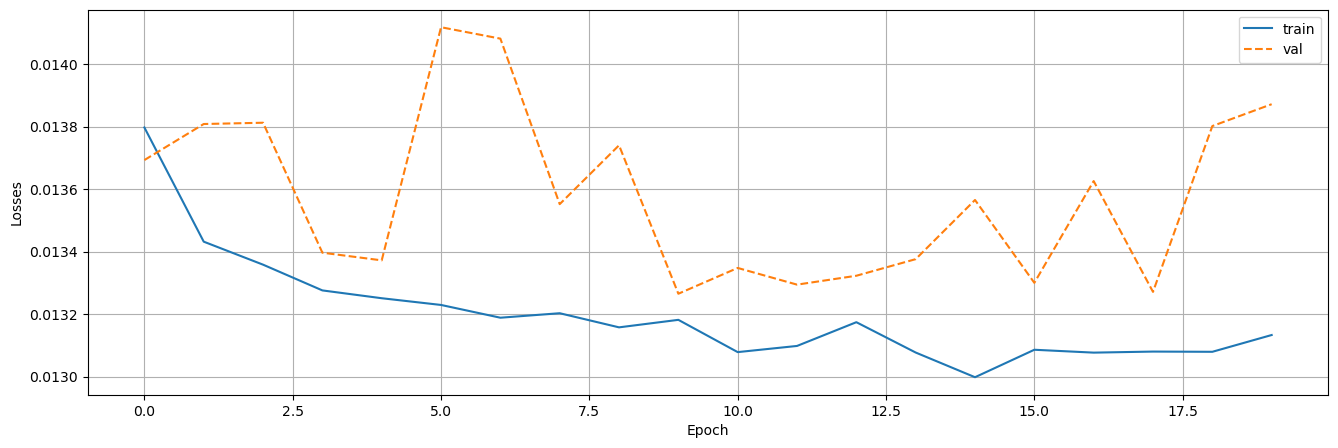

In [24]:
plt.figure(figsize = (16,5))
plt.plot(train_losses,'-',label = f'train')
plt.plot(val_losses,'--',label = f'val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Losses')
plt.grid()
plt.show()  

In [18]:
class FaceDetector(object):
    """
    Face detector class
    """

    def __init__(self, mtcnn, device, capture_name):
        self.mtcnn = mtcnn
        self.device = device
        self.capture_name = capture_name
        self.emodel = torch.load('emotion_detection_SCNN_model.pth')

    def _draw(self, frame, boxes, probs, landmarks, emotions, gesture_):
        """
        Draw landmarks and boxes for each face detected
        """  
        try:
            for box, prob, ld, emotion in zip(boxes, probs, landmarks, emotions):
                # Draw rectangle on frame
                cv2.rectangle(frame,
                              (int(box[0]), int(box[1])),
                              (int(box[2]), int(box[3])),
                              (255, 0, 0),
                              thickness=2)

                # Show probability
                cv2.putText(frame, 
                            emotion, 
                            (int(box[2]), int(box[3])), 
                            cv2.FONT_HERSHEY_SIMPLEX, 
                            1, 
                            (0, 0, 255), 
                            2, 
                            cv2.LINE_AA)
                
                # Show probability
                cv2.putText(frame, 
                            gesture_, 
                            (50, 50), 
                            cv2.FONT_HERSHEY_SIMPLEX, 
                            1, 
                            (0, 0, 255), 
                            2, 
                            cv2.LINE_AA)

                # Draw landmarks
                cv2.circle(frame, (int(ld[0][0]), int(ld[0][1])), 3, (0, 0, 255), -1)
                cv2.circle(frame, (int(ld[1][0]), int(ld[1][1])), 3, (0, 0, 255), -1)
                cv2.circle(frame, (int(ld[2][0]), int(ld[2][1])), 3, (0, 0, 255), -1)
                cv2.circle(frame, (int(ld[3][0]), int(ld[3][1])), 3, (0, 0, 255), -1)
                cv2.circle(frame, (int(ld[4][0]), int(ld[4][1])), 3, (0, 0, 255), -1)
        except:
            pass
        
        return frame
    
    @staticmethod
    def crop_faces(frame, boxes):
        faces = []
        try:
            for i, box in enumerate(boxes):
                faces.append(frame[int(box[1]):int(box[3]), 
                    int(box[0]):int(box[2])])
        except:
            pass
        return faces
    
    @staticmethod
    def digit_to_classname(digit):
        if digit == 0:
            return 'angry'
        elif digit == 1:
            return 'disgust'
        elif digit == 2:
            return 'fear'
        elif digit == 3:
            return 'happy'
        elif digit == 4:
            return 'neutral'
        elif digit == 5:
            return 'sad'
        elif digit == 6:
            return 'surprise'

    def run(self):
        """
            Run the FaceDetector and draw landmarks and boxes around detected faces
        """                
        cv2.namedWindow('Face Detection')
        capture = cv2.VideoCapture(self.capture_name)
        out = cv2.VideoWriter('output.avi', cv2.VideoWriter_fourcc(*'XVID'), 20.0, (640,480))
        self.emodel = self.emodel.to(self.device)
        self.emodel.eval()
        
        if capture.isOpened():
            rval, frame = capture.read()
        else:
            rval = False
        
        while rval:
            cv2.imshow('Face Detection', frame)
            rval, frame = capture.read()
        
            # detect face box, probability and landmarks
            boxes, probs, landmarks = self.mtcnn.detect(frame, landmarks=True)
            
            gesture_ = 'NAN'
            
            try:
                gesture_frame = frame
                gesture_frame = cv2.resize(gesture_frame,(128,128))
                gesture_frame = cv2.cvtColor(gesture_frame, cv2.COLOR_BGR2GRAY)
                torch_gesture = torch.from_numpy(gesture_frame).unsqueeze(0).to(self.device).float()
                gesture_ = detect_gesture_model(torch_gesture[None, ...])
                gesture_ = digit_to_classname_gesture(gesture_.argmax())
            except:
                pass
            
            # crop face from frame
            faces = self.crop_faces(frame, boxes)
            
            # determination of facial emotion
            emotions = []
            for face in faces:
                try:
                    face = cv2.resize(face,(128,128))
    
                    face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
                    torch_face = torch.from_numpy(face).unsqueeze(0).to(self.device).float()
                    emotion = detect_emotion_model(torch_face[None, ...])
                    emotion = self.digit_to_classname(emotion.argmax())
                    print(f'({emotion}, {gesture_})')
                    emotions.append(emotion)
                except:
                    pass

            # draw on frame
            self._draw(frame, boxes, probs, landmarks, emotions, gesture_)
            emotions = []
            
            # Show the frame
            cv2.imshow('Face Detection', frame)
            out.write(frame)

            key = cv2.waitKey(20)
            if key == 27: # exit on ESC
                break

        capture.release()
        out.release()
        cv2.destroyAllWindows()

In [19]:
detect_emotion_model = SimpleCNN(1, 7)
detect_emotion_model.load_state_dict(torch.load('emotion_detection_SCNN_model_weight.pth'))
detect_emotion_model = detect_emotion_model.to(device)

In [20]:
detect_gesture_model = SimpleCNN_gesture(1, 10)
detect_gesture_model.load_state_dict(torch.load('emotion_detection_SCNN_gesture_model_weight.pth'))
detect_gesture_model = detect_gesture_model.to(device)

In [21]:
# Run the app
mtcnn = MTCNN(keep_all=True, device=device)

# name of a video file or a capturing device or an IP video stream for video capturing with API Preference
capture_name = 0;
fcd = FaceDetector(mtcnn, device, capture_name)
fcd.run()
cuda.close()

(neutral, 04_fist_moved)
(sad, 04_fist_moved)
(neutral, 04_fist_moved)
(neutral, 04_fist_moved)
(neutral, 04_fist_moved)
(neutral, 04_fist_moved)
(neutral, 04_fist_moved)
(neutral, 04_fist_moved)
(neutral, 04_fist_moved)
(neutral, 04_fist_moved)
(fear, 04_fist_moved)
(neutral, 04_fist_moved)
(neutral, 04_fist_moved)
(neutral, 04_fist_moved)
(neutral, 04_fist_moved)
(neutral, 04_fist_moved)
(neutral, 04_fist_moved)
(neutral, 04_fist_moved)
(neutral, 04_fist_moved)
(neutral, 04_fist_moved)
(neutral, 04_fist_moved)
(neutral, 04_fist_moved)
(sad, 04_fist_moved)
(sad, 04_fist_moved)
(neutral, 04_fist_moved)
(neutral, 04_fist_moved)
(neutral, 04_fist_moved)
(neutral, 04_fist_moved)
(sad, 04_fist_moved)
(sad, 04_fist_moved)
(sad, 04_fist_moved)
(sad, 04_fist_moved)
(sad, 04_fist_moved)
(neutral, 04_fist_moved)
(sad, 04_fist_moved)
(neutral, 04_fist_moved)
(sad, 02_l)
(sad, 02_l)
(sad, 04_fist_moved)
(sad, 09_c)
(neutral, 09_c)
(neutral, 04_fist_moved)
(neutral, 04_fist_moved)
(neutral, 04_fis

(surprise, 04_fist_moved)
(surprise, 04_fist_moved)
(surprise, 04_fist_moved)
(surprise, 04_fist_moved)
(surprise, 04_fist_moved)
(surprise, 04_fist_moved)
(surprise, 04_fist_moved)
(surprise, 04_fist_moved)
(surprise, 04_fist_moved)
(surprise, 04_fist_moved)
(surprise, 04_fist_moved)
(surprise, 04_fist_moved)
(surprise, 04_fist_moved)
(fear, 04_fist_moved)
(surprise, 04_fist_moved)
(fear, 04_fist_moved)
(fear, 04_fist_moved)
(neutral, 04_fist_moved)
(happy, 04_fist_moved)
(happy, 04_fist_moved)
(neutral, 04_fist_moved)
(happy, 04_fist_moved)
(happy, 04_fist_moved)
(happy, 04_fist_moved)
(happy, 04_fist_moved)
(happy, 04_fist_moved)
(happy, 04_fist_moved)
(happy, 04_fist_moved)
(happy, 04_fist_moved)
(happy, 04_fist_moved)
(happy, 04_fist_moved)
(happy, 04_fist_moved)
(happy, 04_fist_moved)
(happy, 04_fist_moved)
(happy, 04_fist_moved)
(happy, 04_fist_moved)
(happy, 04_fist_moved)
(happy, 04_fist_moved)
(happy, 04_fist_moved)
(happy, 04_fist_moved)
(happy, 04_fist_moved)
(happy, 04_fis